In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# %qtconsole

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

np.random.seed(1234)

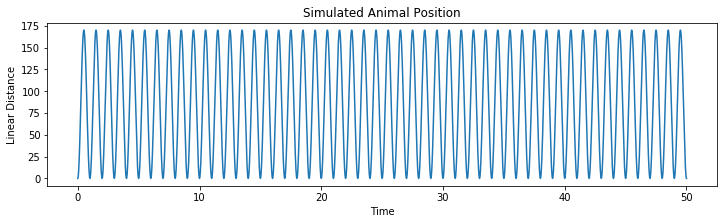

In [3]:
SAMPLING_FREQUENCY = 1500
N_SAMPLES = SAMPLING_FREQUENCY * 50
TRACK_HEIGHT = 170
fig = plt.figure(figsize=(12, 3))
time = np.arange(N_SAMPLES) / SAMPLING_FREQUENCY
linear_distance = (TRACK_HEIGHT / 2) * np.sin(2 * np.pi * time - (np.pi) / 2) + (TRACK_HEIGHT / 2)
plt.plot(time, linear_distance);
plt.ylabel('Linear Distance')
plt.xlabel('Time')
plt.title('Simulated Animal Position');

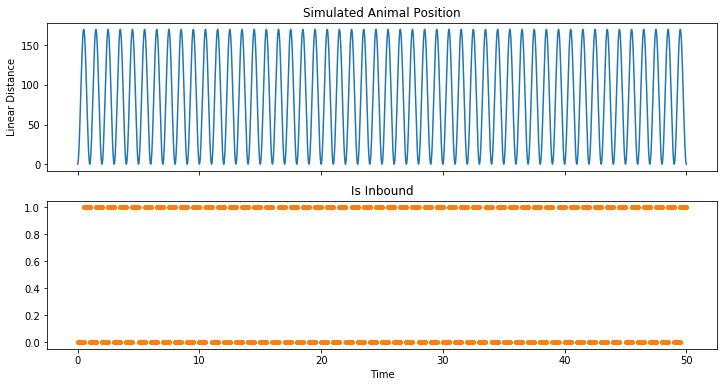

In [4]:
is_inbound = np.insert(np.diff(linear_distance) < 0, 0, False)
trajectory_direction = np.where(is_inbound, 'Inbound', 'Outbound')

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
time = np.arange(N_SAMPLES) / SAMPLING_FREQUENCY
linear_distance = (TRACK_HEIGHT / 2) * np.sin(2 * np.pi * time - (np.pi) / 2) + (TRACK_HEIGHT / 2)
axes[0].plot(time, linear_distance);
axes[0].set_ylabel('Linear Distance')
axes[1].set_xlabel('Time')
axes[0].set_title('Simulated Animal Position');

axes[1].plot(time, is_inbound, color='C1', linestyle='None', marker='.')
axes[1].set_title('Is Inbound');

In [5]:
from scipy.stats import norm
from scipy.stats import poisson

def simulate_poisson_place_field(place_field_mean, linear_distance, sampling_frequency,
                                 place_field_std_deviation=20, scaling_factor=3E2,
                                 baseline_firing_rate=2):
    dt = 1 / sampling_frequency
    firing_rate = (baseline_firing_rate + 
                   scaling_factor * norm(place_field_mean, place_field_std_deviation).pdf(linear_distance))
    return 1.0 * (poisson.rvs(firing_rate * dt).T > 0)

def simulate_spike_marks(place_field_means, mark_means, sampling_frequency, linear_distance,
                         baseline_firing_rate=2, place_field_std_deviation=40, mark_std_deviation=200,
                        scaling_factor=3E2):
    '''Simulate a single tetrode assuming each tetrode picks up several neurons with different place fields
    with distinguishing marks.'''
    n_marks = mark_means.size
    
    def _generate_marks(place_field_mean, mark_mean):
        '''Generate a place field with an associated mark'''
        spikes = simulate_poisson_place_field(
            place_field_mean, linear_distance, sampling_frequency,
            place_field_std_deviation, scaling_factor, baseline_firing_rate)
        spikes[spikes == 0] = np.nan
        return norm(mark_mean,  mark_std_deviation).rvs(size=(spikes.size, n_marks)) * spikes[:, np.newaxis]

    spike_marks = np.nanmean(np.stack(
        [_generate_marks(place_field_mean, mark_mean)
         for place_field_mean, mark_mean in zip(place_field_means, mark_means)]),
                         axis=0)
    return spike_marks

In [6]:
mark_means  = np.array([200, 190, 300, 220])
place_field_means = np.stack((np.arange(0, 200, 50),
                              np.arange(25, 200, 50)))

spike_marks = np.stack(
    [simulate_spike_marks(place_field_means[0], mark_means, SAMPLING_FREQUENCY, linear_distance) * is_inbound[:, np.newaxis],
     simulate_spike_marks(place_field_means[1], mark_means, SAMPLING_FREQUENCY, linear_distance) * is_inbound[:, np.newaxis],
     simulate_spike_marks(place_field_means[0], mark_means, SAMPLING_FREQUENCY, linear_distance) * ~is_inbound[:, np.newaxis],
     simulate_spike_marks(place_field_means[1], mark_means, SAMPLING_FREQUENCY, linear_distance) * ~is_inbound[:, np.newaxis],
    ], axis=0)

/Users/edeno/anaconda3/envs/Replay-Content-Classification/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


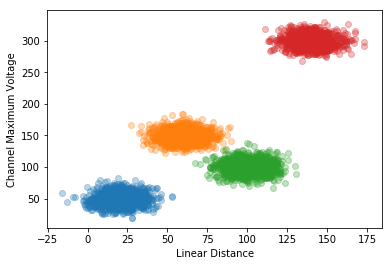

In [7]:
from scipy.stats import multivariate_normal

for distance, mark1 in zip(np.arange(20, 160, 40), [50, 150, 100, 300]):
    m = multivariate_normal.rvs(mean=[distance, mark1], cov=100, size=1000)
    plt.scatter(m[:, 0], m[:, 1], alpha=0.3)
    plt.xlabel('Linear Distance')
    plt.ylabel('Channel Maximum Voltage');

In [8]:
from replay_classification import ClusterlessDecoder

decoder = ClusterlessDecoder(
    position=linear_distance,
    trajectory_direction=trajectory_direction,
    spike_marks=spike_marks,
    replay_speedup_factor=1,
)

/Users/edeno/anaconda3/envs/Replay-Content-Classification/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
decoder.fit()

INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


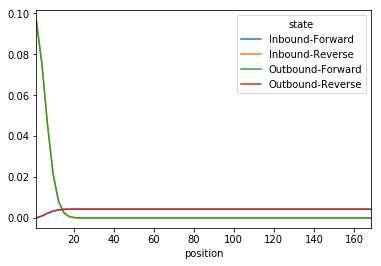

In [10]:
decoder.plot_initial_conditions();

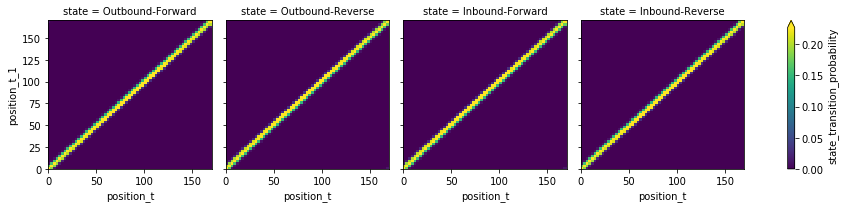

In [11]:
decoder.plot_state_transition_model();

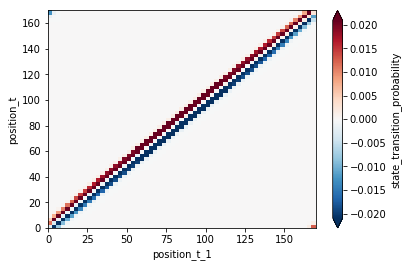

In [12]:
state_transition = decoder.state_transition_matrix

(state_transition.sel(state='Outbound-Forward') - state_transition.sel(state='Inbound-Forward')).plot(
    x='position_t_1', y='position_t', robust=True);

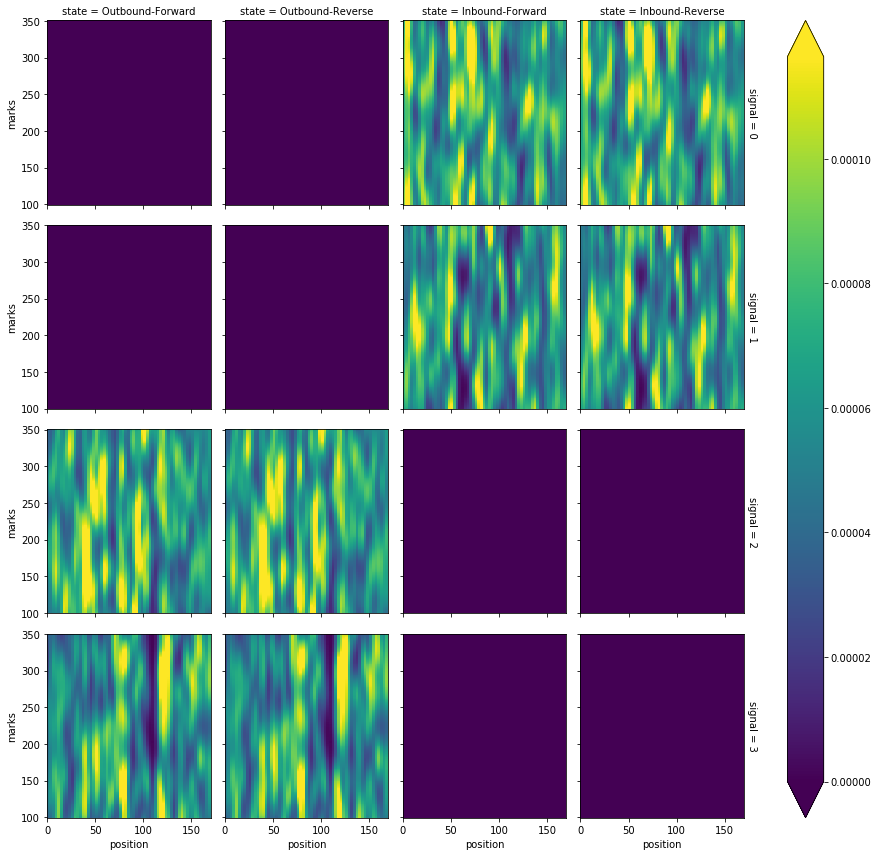

In [13]:
decoder.plot_observation_model();

### Outbound-Forward

In [14]:
outbound_time = time < 0.5
outbound_results = decoder.predict(spike_marks[:, outbound_time, :], time=time[outbound_time])

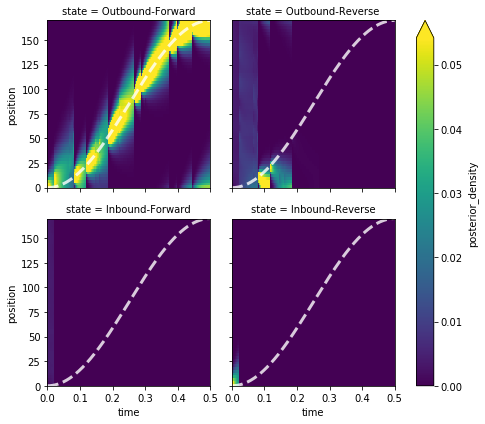

In [15]:
g = outbound_results.plot_posterior_density()

for ax in g.axes.ravel().tolist():
    ax.plot(time[outbound_time], linear_distance[outbound_time], color='white', linestyle='--', linewidth=3, alpha=0.8)

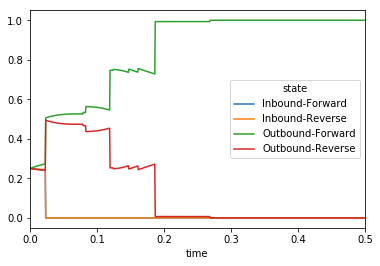

In [16]:
outbound_results.plot_state_probability();

### Inbound-Forward

In [17]:
inbound_time = (time > 1.5) & (time <= 2)
inbound_results = decoder.predict(spike_marks[:, inbound_time, :], time=time[inbound_time])

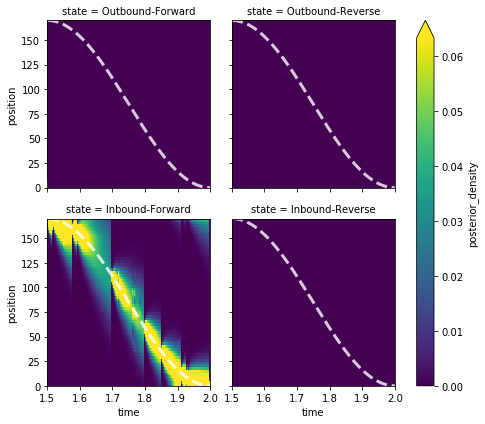

In [18]:
g = inbound_results.plot_posterior_density()

for ax in g.axes.ravel().tolist():
    ax.plot(time[inbound_time], linear_distance[inbound_time], color='white', linestyle='--', linewidth=3, alpha=0.8)

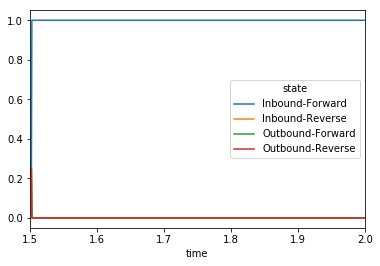

In [19]:
inbound_results.plot_state_probability();